# Maximizing Customer Retention: Fairway Bank (Modeling 2)

We will now build models to predict churn without the 'complain' feature. We will also adjust the probability threshold for a more conservative churn prediction. After all, our highest priority is to minimize false negatives. The first round of modeling can be found  __[here](https://github.com/da42ru/Fairway_Bank_Churn_Reduction/blob/main/notebooks/03_modeling.ipynb)__.

## Load Libraries

In [2016]:
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm

import re

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, make_scorer, recall_score, f1_score

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import pickle

## Load Data

In [314]:
df = pd.read_csv('bank_4.csv', index_col=0)

In [316]:
df.head()

,credit_score,gender,age,tenure,balance,num_products,credit_card,active,salary,churn,...,points,country_F,country_G,country_S,card_D,card_G,card_P,card_S,umap_1,umap_2
0,1,0,2,2,0,1,1,1,2,1,...,2,1,0,0,1,0,0,0,-3.143583,0.786093
1,1,0,2,1,1,1,0,1,2,0,...,2,0,0,1,1,0,0,0,10.020865,-11.832602
2,0,0,2,8,3,3,1,0,2,1,...,1,1,0,0,1,0,0,0,-3.809586,-0.268657
3,2,0,2,1,0,2,0,0,1,0,...,1,1,0,0,0,1,0,0,-8.133482,3.541135
4,3,0,2,2,2,1,1,1,1,0,...,2,0,0,1,0,1,0,0,1.444620,-6.639251


In [318]:
df.shape

(10000, 22)

## Train / Test Split

In [321]:
# We will now build models without the 'complain' feature (we also exclude umap features as these were derived from data including 'complain')

X = df.drop(columns=['churn', 'complain', 'umap_1', 'umap_2'])
y = df['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [323]:
print(f'Train shape: {X_train.shape, y_train.shape}')
print(f'Test shape: {X_test.shape, y_test.shape}')

Train shape: ((8000, 18), (8000,))
Test shape: ((2000, 18), (2000,))


## Initial Recall

To establish a baseline, let's compare model recall across all models that we previously tried, but without the 'complain' feature.

In [955]:
# Establish cross-validator

skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

In [984]:
# Variable for recall metric

rs = recall_score

In [957]:
# Cross-validate model recall on train data

def initial_recall(model):
    scores = cross_val_score(model, X_train, y_train, scoring=make_scorer(rs), cv=skf, n_jobs=-1)
    return np.mean(scores)

In [959]:
# Untuned models

rf = RandomForestClassifier(random_state=42)
et = ExtraTreesClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)
hgb = HistGradientBoostingClassifier(random_state=42)
ab = AdaBoostClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)
lgb = LGBMClassifier(random_state=42, verbose=-1)
cb = CatBoostClassifier(random_state=42, verbose=0)
lr = LogisticRegression(random_state=42)
sv = SVC(random_state=42, probability=True)

m_names = ['RandomForest', 'ExtraTrees', 'GradientBoosting', 'HistGradientBoosting', 'AdaBoost',
           'XGBoost', 'LightGBM', 'CatBoost', 'LogisticRegression', 'SupportVector']

models = [rf, et, gb, hgb, ab, xgb, lgb, cb, lr, sv]

In [961]:
# Check initial recall for each model

for n, m in zip(m_names, models):
    print(n, initial_recall(m), '\n')

RandomForest 0.42392638036809827 

ExtraTrees 0.39631901840490796 

GradientBoosting 0.4368098159509202 

HistGradientBoosting 0.46932515337423314 

AdaBoost 0.44601226993865034 

XGBoost 0.4742331288343558 

LightGBM 0.4742331288343558 

CatBoost 0.450920245398773 

LogisticRegression 0.21840490797546014 

SupportVector 0.0018404907975460125 



As expected, recall drops significantly without the 'complain' feature. Recall (pun intended) that it was by far the most important feature in all models except for LightGBM (which ranked 'tenure' as most important and only ranked 'complain' as 10th most important), and Hist Gradient Boosting, Logistic Regression, and Support Vector, which all don't have a feature importances attribute.

Without the golden feature, no models were even able to accurately predict half of the total churn cases. The bet two models were XGBoost and LightGBM, each with a recall score of about 47%. One way to mitigate these low scores is to lower our models' probability threshold from the default 50%. If we went with a probability threshold of say, 20%, we would assign a churn prediction to any customer that has at least a 20% chance of churning. This ought to reduce our false negatives, as we will be predicting more overall positive cases. Let's see this in effect.

## Probability Thresholds / F1-Score

In [1251]:
# Cross-validate model performance with custom metric and probability threshold

def cv(model, metric, threshold=0.5):
    
    scores = []
    
    for tr, te in skf.split(X_train, y_train):
        
        X_tr, X_te = X_train.iloc[tr], X_train.iloc[te]
        y_tr, y_te = y_train.iloc[tr], y_train.iloc[te]
        
        prob = model.fit(X_tr, y_tr).predict_proba(X_te)[:, 1]
        y_pred = np.where(prob < threshold, 0, 1)
        
        scores.append(metric(y_te, y_pred))
        
    return np.mean(scores)

In [974]:
# Check recall for each model with a 20% probability threshold

for n, m in zip(m_names, models):
    print(n, cv(m, rs, 0.2), '\n')

RandomForest 0.7865030674846626 

ExtraTrees 0.7736196319018406 

GradientBoosting 0.749079754601227 

HistGradientBoosting 0.7380368098159509 

AdaBoost 1.0 

XGBoost 0.6834355828220858 

LightGBM 0.7368098159509202 

CatBoost 0.7411042944785275 

LogisticRegression 0.6957055214723926 

SupportVector 0.6619631901840491 



These scores look a lot better, but the strategy of simply reducing the probability threshold to increase recall comes with a major caveat. What if we were to reduce the probability threshold to 0.01? Any customer predicted to have at least a 1% chance of churning would be predicted to churn. We would have very few false negatives because we would have very few negative predictions! In this case we would have a high number of false positives and thus a low precision, deeming our model unhelpful. To see this in effect, let's plot a confusion matrix for each model to see the ratio of false negatives to false positives.

In [1253]:
# Evaluate confusion matrix of model with custom probability threshold

def cm(model, threshold):
    prob = model.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    y_pred = np.where(prob < threshold, 0, 1)
    return confusion_matrix(y_test, y_pred)

In [978]:
# Produce confusion matrix for each model with 0.1 probability threshold

for n, m in zip(m_names, models):
    print(n, '\n', cm(m, 0.01), '\n')

RandomForest 
 [[  62 1530]
 [   2  406]] 

ExtraTrees 
 [[ 129 1463]
 [   3  405]] 

GradientBoosting 
 [[   3 1589]
 [   0  408]] 

HistGradientBoosting 
 [[  97 1495]
 [   3  405]] 

AdaBoost 
 [[   0 1592]
 [   0  408]] 

XGBoost 
 [[ 351 1241]
 [  10  398]] 

LightGBM 
 [[  65 1527]
 [   2  406]] 

CatBoost 
 [[ 138 1454]
 [   3  405]] 

LogisticRegression 
 [[   0 1592]
 [   0  408]] 

SupportVector 
 [[   0 1592]
 [   0  408]] 



As expected, each model has very few false negative predictions (bottom left) because each model predicts few overall negative outcomes (total left). Interestingly, even with a 1% probability threshold, XGBoost still predicted 351 negative cases. On the contrary, we see that for every model, about 3/4 of the predictions are false positives. We thus will use f1-score as a metric to determine an optimum probability threshold, as we  aim to maximize recall whilst minimizing the sacrifice to precision.

In [982]:
# Variable for f1-score metric

f1 = f1_score

In [377]:
# Test different probability thresholds for each model to optimize f1-score

thresholds1 = [0.5, 0.4, 0.3, 0.2, 0.1]

for n, m in zip(m_names, models):
    print(n)
    for t in thresholds1:
        print(f'{t} probability threshold: f1-score = {cv(m, f1, t)}')
    print('\n')

RandomForest
0.5 probability threshold: f1-score = 0.5440611353290233
0.4 probability threshold: f1-score = 0.5850606346475127
0.3 probability threshold: f1-score = 0.5960607270151228
0.2 probability threshold: f1-score = 0.556436860281932
0.1 probability threshold: f1-score = 0.45817934981927627


ExtraTrees
0.5 probability threshold: f1-score = 0.5163401576425288
0.4 probability threshold: f1-score = 0.5650005697841534
0.3 probability threshold: f1-score = 0.5821982451527006
0.2 probability threshold: f1-score = 0.5440709808946063
0.1 probability threshold: f1-score = 0.4652277466792669


GradientBoosting
0.5 probability threshold: f1-score = 0.5538113026965544
0.4 probability threshold: f1-score = 0.598785902256514
0.3 probability threshold: f1-score = 0.6127876188812609
0.2 probability threshold: f1-score = 0.5905652323353194
0.1 probability threshold: f1-score = 0.49913848752451095


HistGradientBoosting
0.5 probability threshold: f1-score = 0.5683968854829073
0.4 probability thre

In general, the highest f1-score is achieved at a 0.3 probability threshold. Exceptions include AdaBoost, in which 0.5 yields the highest score, and Logistic Regression, in which 0.2 yields a higher score. Let's run another custom grid search over values surrounding 0.3 to see if there is an even higher point that is more precise.

In [380]:
# Test a range of probability thresholds between 0.4 and 0.2 exclusive

thresholds2 = [0.38, 0.36, 0.34, 0.32, 0.3, 0.28, 0.26, 0.24, 0.22]

for n, m in zip(m_names, models):
    print(n)
    for t in thresholds2:
        print(f'{t} probability threshold: f1-score = {cv(m, f1, t)}')
    print('\n')

RandomForest
0.38 probability threshold: f1-score = 0.5918424241635408
0.36 probability threshold: f1-score = 0.594774479209491
0.34 probability threshold: f1-score = 0.5993632070942655
0.32 probability threshold: f1-score = 0.5982353326731819
0.3 probability threshold: f1-score = 0.5960607270151228
0.28 probability threshold: f1-score = 0.5952200663202183
0.26 probability threshold: f1-score = 0.5894528771094368
0.24 probability threshold: f1-score = 0.5777326386758421
0.22 probability threshold: f1-score = 0.5664885980853669


ExtraTrees
0.38 probability threshold: f1-score = 0.5769247124240028
0.36 probability threshold: f1-score = 0.574718235747022
0.34 probability threshold: f1-score = 0.5811152451815876
0.32 probability threshold: f1-score = 0.5824968723248477
0.3 probability threshold: f1-score = 0.5821982451527006
0.28 probability threshold: f1-score = 0.5773188075955608
0.26 probability threshold: f1-score = 0.5678033040483
0.24 probability threshold: f1-score = 0.563616412281

F1-scores peaks at the following probability thresholds for the following models:

0.34
- Random Forest
- LightGBM

0.32
- Extra Trees
- Gradient Boosting

0.3
- Hist Gradient Boosting
- XGBoost

0.28
- CatBoost
- Support Vector

0.24
- Logistic Regression
    
AdaBoost is consistent across the range. Finally, we will find the specific value (rounded to 1%) for a probability threshold for each model that optimizes f1-score.

In [397]:
# Custom grid search best probability threshold (in terms of subsequent f1-score) per model

for n, m in zip(m_names, models):
    
    if n == 'RandomForest' or n == 'LightGBM':
        thresholds3 = [0.35, 0.34, 0.33]
    elif n == 'ExtraTrees' or n == 'GradientBoosting':
        thresholds3 = [0.33, 0.32, 0.31]
    elif n == 'HistGradientBoosting' or n == 'XGBoost':
        thresholds3 = [0.31, 0.3, 0.29]
    elif n=='CatBoost' or n=='SupportVector':
        thresholds3 = [0.29, 0.28, 0.27]
    elif n=='LogisticRegression':
        thresholds3 = [0.25, 0.24, 0.23]
    else:
        thresholds3 = [0.54, 0.52, 0.5, 0.48, 0.46] #AdaBoost
    
    print(n)
    for t in thresholds3:
        print(f'{t} probability threshold: f1-score = {cv(m, f1, t)}')
    print('\n')

RandomForest
0.35 probability threshold: f1-score = 0.5952018860321797
0.34 probability threshold: f1-score = 0.5993632070942655
0.33 probability threshold: f1-score = 0.5984577252856096


ExtraTrees
0.33 probability threshold: f1-score = 0.5793093834056374
0.32 probability threshold: f1-score = 0.5824968723248477
0.31 probability threshold: f1-score = 0.5817013666768758


GradientBoosting
0.33 probability threshold: f1-score = 0.6151704953718828
0.32 probability threshold: f1-score = 0.6150513645952291
0.31 probability threshold: f1-score = 0.6135863274358225


HistGradientBoosting
0.31 probability threshold: f1-score = 0.614298852505534
0.3 probability threshold: f1-score = 0.6140039977193348
0.29 probability threshold: f1-score = 0.6125706568037317


AdaBoost
0.54 probability threshold: f1-score = 0.0
0.52 probability threshold: f1-score = 0.0349294505696469
0.5 probability threshold: f1-score = 0.546939803877357
0.48 probability threshold: f1-score = 0.35515394978222076
0.46 probab

In [400]:
# Refined custom grid search for AdaBoost with thresholds rounded to 1%

print('AdaBoost')
for t in [0.51, 0.5, 0.49]:
    print(f'{t} probability threshold: f1-score = {cv(ab, f1, t)}')

AdaBoost
0.51 probability threshold: f1-score = 0.17846247481913893
0.5 probability threshold: f1-score = 0.546939803877357
0.49 probability threshold: f1-score = 0.513806027541478


Each models' probability threshold that optimizes f1-score is as follows:

Random Forest: 0.34

Extra Trees: 0.32

Gradient Boosting: 0.33

Hist Gradient Boosting: 0.31

AdaBoost: 0.5

XGBoost: 0.3

LightGBM: 0.34

CatBoost: 0.29

Logistic Regression: 0.25

Support Vector: 0.27

In [403]:
# List of best probability thresholds in same order as respective model

thresholds = [0.34, 0.32, 0.33, 0.31, 0.5, 0.3, 0.34, 0.29, 0.25, 0.27]

In [409]:
# Assess recall for each model with it's best f1-score probability threshold

for n, m, t in zip(m_names, models, thresholds):
    print(n, cv(m, rs, t), '\n')

RandomForest 0.6036809815950919 

ExtraTrees 0.6251533742331289 

GradientBoosting 0.5932515337423313 

HistGradientBoosting 0.6269938650306748 

AdaBoost 0.44601226993865034 

XGBoost 0.6110429447852761 

LightGBM 0.6061349693251533 

CatBoost 0.6331288343558281 

LogisticRegression 0.5914110429447852 

SupportVector 0.5558282208588957 



In general, models produce a recall of ~60%, with AdaBoost underperforming at just below 45% recall. Catboost has the best recall score of over 63%.

In [989]:
# Assess f1-score for each model with it's best f1-score probability threshold

for n, m, t in zip(m_names, models, thresholds):
    print(n, cv(m, f1, t), '\n')

RandomForest 0.5993632070942655 

ExtraTrees 0.5824968723248477 

GradientBoosting 0.6151704953718828 

HistGradientBoosting 0.614298852505534 

AdaBoost 0.546939803877357 

XGBoost 0.5857865488759687 

LightGBM 0.6155720169564236 

CatBoost 0.6050044186423656 

LogisticRegression 0.488558613144468 

SupportVector 0.5483128317751622 



In general, models produce a f1-score of a little under ~60%, with Logistic Regression underperforming with an f1-score just below 49%. LightGBM has the best f1-score of over 61%.

With optimal probability thresholds for each model, we can now tune hyperparameters. As our goal is still to minimize false negatives, we will tune each model to optimize recall. However we will also tune an additional model of each type that optimizes f1-score. We can then compare the prediction results of each to ensure that we minimize false negative without predicting too many false positives.

## Hyperparameter Tuning

Hyperparameter tuning for each model can be found in the following notebooks:

Random Forest: __[recall](https://github.com/da42ru/Fairway_Bank_Churn_Reduction/blob/main/hyperparameter_tuning/10_rf_recall.ipynb)__, __[f1-score](https://github.com/da42ru/Fairway_Bank_Churn_Reduction/blob/main/hyperparameter_tuning/00_rf_f1score.ipynb)__

Extra Trees: __[recall](https://github.com/da42ru/Fairway_Bank_Churn_Reduction/blob/main/hyperparameter_tuning/11_et_recall.ipynb)__, __[f1-score](https://github.com/da42ru/Fairway_Bank_Churn_Reduction/blob/main/hyperparameter_tuning/01_et_f1score.ipynb)__

Gradient Boosting: __[recall](https://github.com/da42ru/Fairway_Bank_Churn_Reduction/blob/main/hyperparameter_tuning/12_gb_recall.ipynb)__, __[f1-score](https://github.com/da42ru/Fairway_Bank_Churn_Reduction/blob/main/hyperparameter_tuning/02_gb_f1score.ipynb)__

Hist Gradient Boosting: __[recall](https://github.com/da42ru/Fairway_Bank_Churn_Reduction/blob/main/hyperparameter_tuning/13_hgb_recall.ipynb)__, __[f1-score](https://github.com/da42ru/Fairway_Bank_Churn_Reduction/blob/main/hyperparameter_tuning/03_hgb_f1score.ipynb)__

AdaBoost: __[recall](https://github.com/da42ru/Fairway_Bank_Churn_Reduction/blob/main/hyperparameter_tuning/14_ab_recall.ipynb)__, __[f1-score](https://github.com/da42ru/Fairway_Bank_Churn_Reduction/blob/main/hyperparameter_tuning/04_ab_f1score.ipynb)__

XGBoost: __[recall](https://github.com/da42ru/Fairway_Bank_Churn_Reduction/blob/main/hyperparameter_tuning/15_xgb_recall.ipynb)__, __[f1-score](https://github.com/da42ru/Fairway_Bank_Churn_Reduction/blob/main/hyperparameter_tuning/05_xgb_f1score.ipynb)__

LightGBM: __[recall](https://github.com/da42ru/Fairway_Bank_Churn_Reduction/blob/main/hyperparameter_tuning/16_lgb_recall.ipynb)__, __[f1-score](https://github.com/da42ru/Fairway_Bank_Churn_Reduction/blob/main/hyperparameter_tuning/06_lgb_f1score.ipynb)__

CatBoost: __[recall](https://github.com/da42ru/Fairway_Bank_Churn_Reduction/blob/main/hyperparameter_tuning/17_cb_recall.ipynb)__, __[f1-score](https://github.com/da42ru/Fairway_Bank_Churn_Reduction/blob/main/hyperparameter_tuning/07_cb_f1score.ipynb)__

Logistic Regression: __[recall](https://github.com/da42ru/Fairway_Bank_Churn_Reduction/blob/main/hyperparameter_tuning/18_lr_recall.ipynb)__, __[f1-score](https://github.com/da42ru/Fairway_Bank_Churn_Reduction/blob/main/hyperparameter_tuning/08_lr_f1score.ipynb)__

Support Vector: __[recall](https://github.com/da42ru/Fairway_Bank_Churn_Reduction/blob/main/hyperparameter_tuning/19_sv_recall.ipynb)__, __[f1-score](https://github.com/da42ru/Fairway_Bank_Churn_Reduction/blob/main/hyperparameter_tuning/09_rf_f1score.ipynb)__

Now that the models are all tuned, with a version for each success metric (recall and f1-score) we are ready to evaluate each model. For each model type, we will evaluate a confusion matrix and classification report to determine if tuning the model for recall or f1-score yields the preferable result for the business. In addition to comparing model performance, we will also consider feature importances, and determine with which features each model performs best. Finally, we will pick a best model and the most important features to present to stakeholders.

## Model Evaluation / Feature Importances

In [1606]:
# Set probability threshold according to model

def set_thresh(model):
    
    model_string = str(model)

    if re.match(r'^(R|LG)', model_string):
        threshold = 0.34
    elif re.match(r'^E', model_string):
        threshold = 0.32
    elif re.match(r'^G', model_string):
        threshold = 0.33
    elif re.match(r'^H', model_string):
        threshold = 0.31
    elif re.match(r'^A', model_string):
        threshold = 0.5
    elif re.match(r'^X', model_string):
        threshold = 0.3
    elif re.match(r'^<', model_string):
        threshold = 0.29
    elif re.match(r'^L', model_string):
        threshold = 0.25
    else:
        threshold = 0.27
    
    return threshold

In [1639]:
# Generate arrays of cross-validated true and predicted labels to use in confusion matrix and classification report
# This function allows us to evaluate model performance without using the test set

def cv_preds(model):
    
    threshold = set_thresh(model)

    trues = np.array([], int)
    preds = np.array([], int)

    for tr, te in skf.split(X_train, y_train):
        
        X_tr, X_te = X_train.iloc[tr], X_train.iloc[te]
        y_tr, y_te = y_train.iloc[tr], y_train.iloc[te]
        
        prob = model.fit(X_tr, y_tr).predict_proba(X_te)[:, 1]
        y_pred = np.where(prob < threshold, 0, 1)
    
        trues = np.append(trues, y_te)
        preds = np.append(preds, y_pred)
    
    return trues, preds

In [1641]:
# Compare confustion matrix for each model of same type, relative to if the model is tuned to optimize recall or f1-score

def cm_comp(model1, model2):
    
    ''' model1 - the model tuned to optimize recall
        model2 - the model tuned to optimize f1-score '''
        
    m_list = [model1, model2]
    
    fig, axes = plt.subplots(1, 2)

    for i in range(2):
        
        trues = cv_preds(m_list[i])[0]
        preds = cv_preds(m_list[i])[1]
        
        cf = ConfusionMatrixDisplay(confusion_matrix(trues, preds))
        cf.plot(ax=axes[i], colorbar=False)
        if i == 0:
            cf.ax_.set_ylabel('True')
            cf.ax_.set_title('Recall Optimizer')
        else:
            cf.ax_.set_ylabel('')
            cf.ax_.set_title('F1-Score Optimizer')
        cf.ax_.set_xlabel('Predicted')

In [1643]:
# Compare classification report for each model of same type, relative to if the model is tuned to optimize recall or f1-score

def cr_comp(model1, model2):
    
    ''' model1 - the model tuned to optimize recall
        model2 - the model tuned to optimize f1-score '''
    
    m_list = [model1, model2]
    n_list = ['Recall Optimizer', 'F1-Score Optimizer']
    
    for i in range(2):
        
        trues = cv_preds(m_list[i])[0]
        preds = cv_preds(m_list[i])[1]
        
        print(n_list[i])
        print(classification_report(trues, preds))

In [1645]:
#Evaluate feature importances

def feat_imp(model):
    
    model.fit(X_train, y_train)
    
    # Dataframe
    fi = pd.DataFrame({'Feature':X_train.columns, 'Importance':model.feature_importances_}).sort_values(
                       'Importance', ascending=False).reset_index(drop=True)
    print(fi)
    
    # Bar plot
    plt.subplots(figsize=(10,6))
    ax = sns.barplot(fi, x='Feature', y='Importance')
    plt.xticks(rotation=90)

In [1647]:
# Compare model recall for each possible number of features, descending in importance

def feat_comp(model):
    
    threshold = set_thresh(model)

    model.fit(X_train, y_train)
    fis = list(pd.Series(model.feature_importances_, X_train.columns).sort_values(ascending=False).index)
    
    features = []
    recall_scores = []
    f1_scores = []
    
    for i in tqdm(range(1, len(X_train.columns)+1)):
    
        subset = X_train[fis[:i]]

        cv_recall = []
        cv_f1 = []
    
        for tr, te in skf.split(subset, y_train):
        
            X_tr, X_te = subset.iloc[tr], subset.iloc[te]
            y_tr, y_te = y_train.iloc[tr], y_train.iloc[te]
        
            prob = model.fit(X_tr, y_tr).predict_proba(X_te)[:, 1]
            y_pred = np.where(prob < threshold, 0, 1)
            
            cv_recall.append(rs(y_te, y_pred))
            cv_f1.append(f1(y_te, y_pred))
        
        features.append(i)
        recall_scores.append(np.mean(cv_recall))
        f1_scores.append(np.mean(cv_f1))
    
    # Dataframe
    fc = pd.DataFrame({'Features': features, 'Recall': recall_scores, 'F1-Score': f1_scores})
    print(fc.set_index('Features'))
    
    # Bar plot
    fcplot = pd.melt(fc, id_vars='Features', value_name='Score')
    plt.subplots(figsize=(10,6))
    ax = sns.lineplot(fcplot, x='Features', y='Score', hue='variable')
    ax.set_xticks(fc['Features'])
    ax.set_xticklabels(fc['Features'])
    ax.legend(title='')

In [1996]:
# Evaluate shap values for a given model

def shapvals(model):
    
    model.fit(X_train, y_train)
    explainer = shap.explainers.Permutation(model.predict_proba, X_train)
    shap_values = explainer(X_train[:100])
    shap_values = shap_values[:,1]
    shap.plots.bar(shap_values)

## Random Forest Classifier

In [1650]:
# Recall optimized model

rf_re = RandomForestClassifier(n_estimators=294, max_features=22, max_depth=49, 
                             min_samples_split=5, random_state=42, n_jobs=-1)

# F1-score optimized model

rf_f1 = RandomForestClassifier(n_estimators=494, max_features=15, max_depth=40, min_samples_split=25, 
                             min_samples_leaf=19, random_state=42, n_jobs=-1)

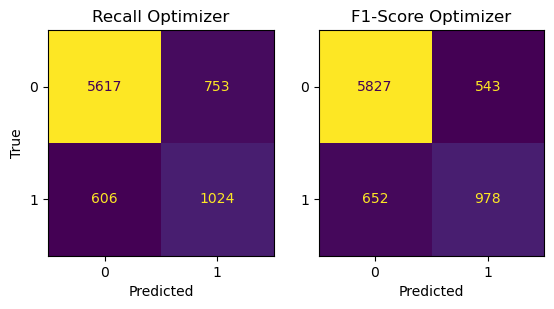

In [1652]:
# Prediction comparisons

cm_comp(rf_re, rf_f1)

In [1656]:
print(f'The recall optimized model has {652-606} fewer false negatives but it has {753-543} more false positives.')

The recall optimized model has 46 fewer false negatives but it has 210 more false positives.


In [1658]:
# Score comparisons

cr_comp(rf_re, rf_f1)

Recall Optimizer
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      6370
           1       0.58      0.63      0.60      1630

    accuracy                           0.83      8000
   macro avg       0.74      0.76      0.75      8000
weighted avg       0.84      0.83      0.83      8000

F1-Score Optimizer
              precision    recall  f1-score   support

           0       0.90      0.91      0.91      6370
           1       0.64      0.60      0.62      1630

    accuracy                           0.85      8000
   macro avg       0.77      0.76      0.76      8000
weighted avg       0.85      0.85      0.85      8000



Overall, the f1-score optimized model looks best.

In [1661]:
# Best model

rfc = rf_f1

         Feature  Importance
0            age    0.307560
1   num_products    0.270744
2         active    0.130140
3        balance    0.078285
4      country_G    0.049589
5         tenure    0.033335
6         points    0.025422
7   satisfaction    0.020025
8         gender    0.018648
9         salary    0.018258
10  credit_score    0.014697
11   credit_card    0.006406
12     country_F    0.006114
13     country_S    0.004713
14        card_P    0.004422
15        card_S    0.004079
16        card_D    0.004048
17        card_G    0.003517


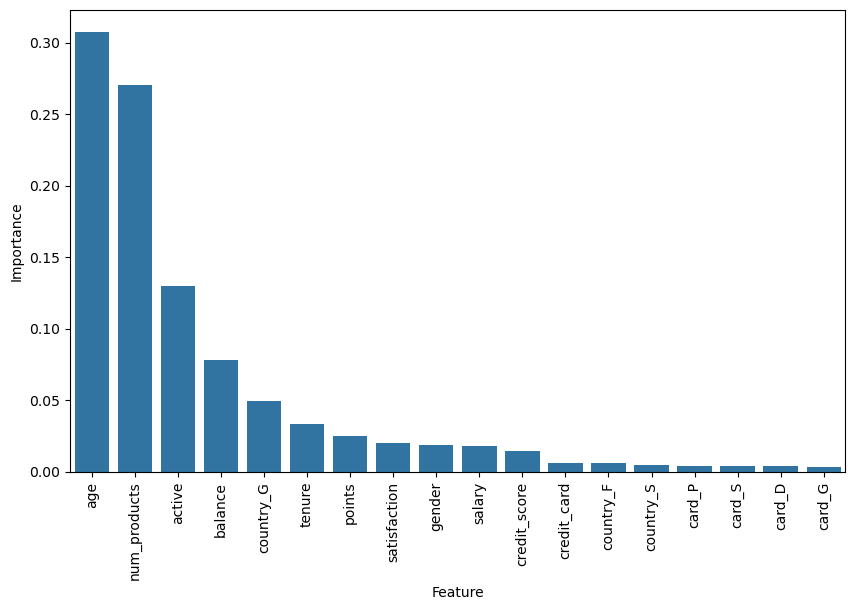

In [1663]:
# Feature importances

feat_imp(rfc)

We see that age and number of products collectively make up 58% of the total feature importances, after which there is a steep drop in importances. Card type and country are least important, except if the customer is from Germany, which is the 5th most important feature! We will later do additional EDA regarding our German customer base.

  0%|          | 0/18 [00:00<?, ?it/s]

            Recall  F1-Score
Features                    
1         0.489571  0.489682
2         0.485890  0.553548
3         0.474847  0.565425
4         0.509816  0.577869
5         0.593865  0.613470
6         0.591411  0.610357
7         0.593865  0.612219
8         0.585276  0.606816
9         0.599387  0.611958
10        0.597546  0.614065
11        0.598773  0.614831
12        0.599387  0.615854
13        0.597546  0.617088
14        0.597546  0.616504
15        0.598160  0.615754
16        0.598160  0.616924
17        0.597546  0.617269
18        0.597546  0.617080


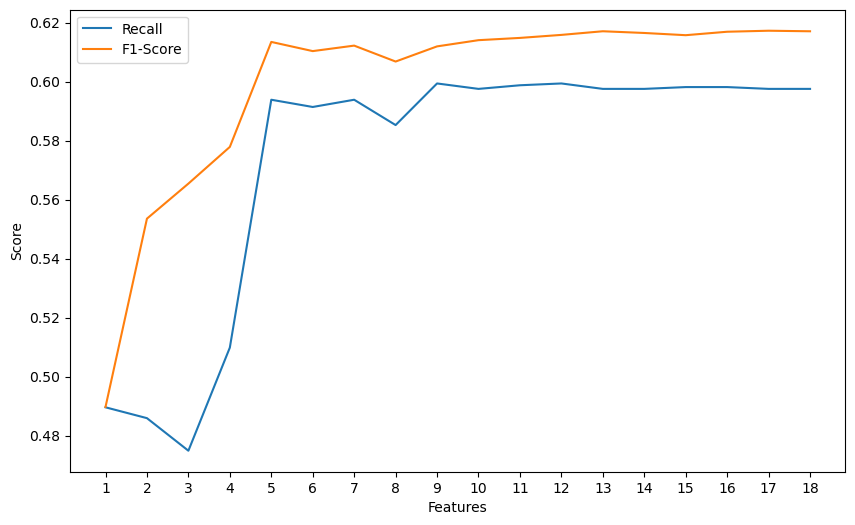

In [1665]:
# Features' effect on model performance

feat_comp(rfc)

The model's recall and f1-score level out after the first 5 features, with a slight improvement overall as more features are added.

## Extra Trees Classifier

In [1669]:
# Recall optimized model

et_re = ExtraTreesClassifier(n_estimators=1567, max_features=47, max_depth=34, min_samples_split=21, 
                           min_samples_leaf=14, random_state=42, n_jobs=-1)

# F1-score optimized model

et_f1 = ExtraTreesClassifier(n_estimators=1374, max_features=23, max_depth=21, min_samples_split=23, 
                             min_samples_leaf=14, random_state=42, n_jobs=-1)

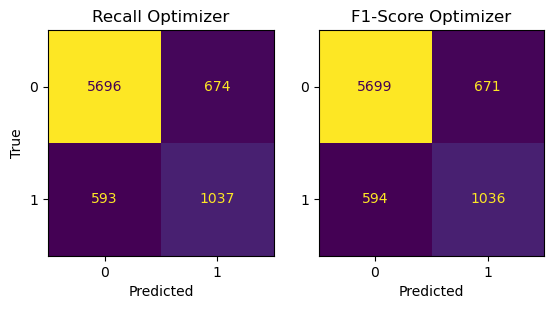

In [1671]:
# Prediction comparisons

cm_comp(et_re, et_f1)

In [1673]:
print(f'The recall optimized model has {594-593} less false negative and {674-671} more false positives.')

The recall optimized model has 1 less false negative and 3 more false positives.


In [1675]:
# Score comparisons

cr_comp(et_re, et_f1)

Recall Optimizer
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      6370
           1       0.61      0.64      0.62      1630

    accuracy                           0.84      8000
   macro avg       0.76      0.77      0.76      8000
weighted avg       0.84      0.84      0.84      8000

F1-Score Optimizer
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      6370
           1       0.61      0.64      0.62      1630

    accuracy                           0.84      8000
   macro avg       0.76      0.77      0.76      8000
weighted avg       0.84      0.84      0.84      8000



Each model's predictions are so similar that the rounded classification report values are identical. We will go with the f1-score optimized model since it had 2 more overall correct predictions.

In [1694]:
# Best model

etc = et_f1

         Feature  Importance
0   num_products    0.324333
1            age    0.286342
2         active    0.097382
3        balance    0.081764
4      country_G    0.058291
5         gender    0.021465
6         salary    0.016378
7   satisfaction    0.014984
8         points    0.013516
9         tenure    0.013105
10  credit_score    0.013046
11   credit_card    0.012766
12        card_G    0.010340
13        card_P    0.009554
14     country_S    0.007204
15        card_D    0.006957
16     country_F    0.006910
17        card_S    0.005663


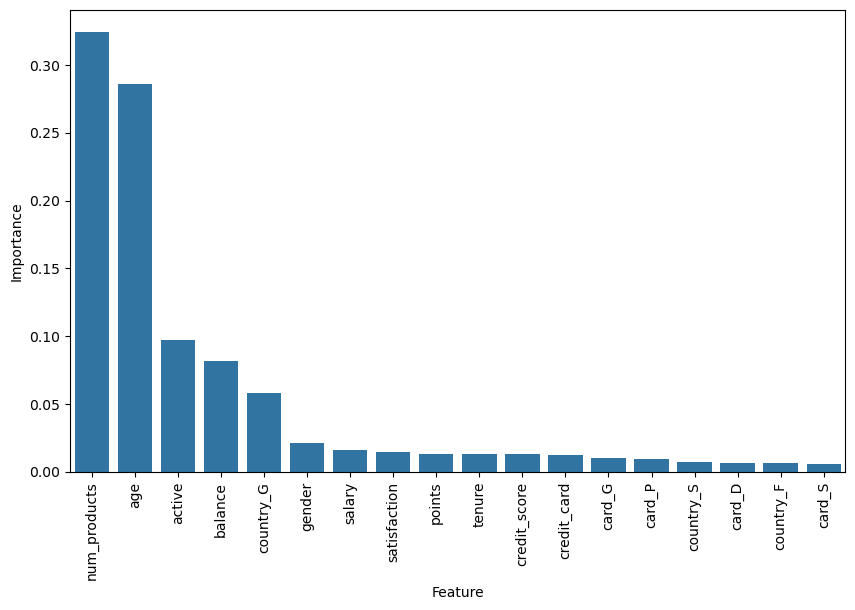

In [1696]:
# Feature importances

feat_imp(etc)

Number of products and age collectively make up about 61% of the feature importances, after which there is a steep drop in importances. Card type and country are least important, except for if the customer is from Germany.

  0%|          | 0/18 [00:00<?, ?it/s]

            Recall  F1-Score
Features                    
1         0.489571  0.489682
2         0.485890  0.553548
3         0.474847  0.565425
4         0.509816  0.577869
5         0.593865  0.613470
6         0.591411  0.610357
7         0.593865  0.612219
8         0.585276  0.606816
9         0.599387  0.611958
10        0.597546  0.614065
11        0.598773  0.614831
12        0.599387  0.615854
13        0.597546  0.617088
14        0.597546  0.616504
15        0.598160  0.615754
16        0.598160  0.616924
17        0.597546  0.617269
18        0.597546  0.617080


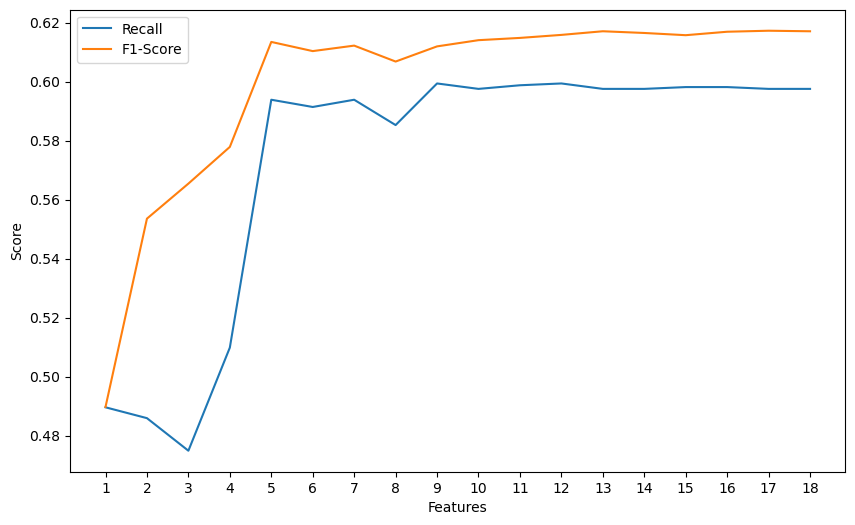

In [1703]:
# Features' effect on model performance

feat_comp(rfc)

The model's recall and f1-score level out after the first 5 features, with a slight improvement overall as more features are added.

## Gradient Boosting Classifier

In [1681]:
# Recall-optimized model

gb_re = GradientBoostingClassifier(n_estimators=1888, learning_rate=0.0031180517539165756, max_depth=6, 
                                   min_samples_split=14, min_samples_leaf=23, random_state=42)

# F1-score optimized model

gb_f1 = GradientBoostingClassifier(n_estimators=1601, learning_rate=0.007484423302277796, max_depth=4, 
                                   min_samples_split=29, min_samples_leaf=10, random_state=42)

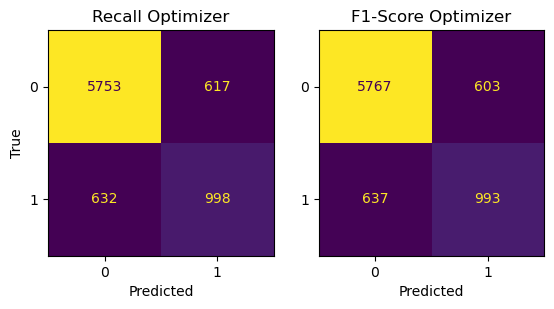

In [1683]:
# Prediction comparisons

cm_comp(gb_re, gb_f1)

In [1698]:
print(f'The recall optimized model has {637-632} fewer false negatives and {617-603} more false positives.')

The recall optimized model has 5 fewer false negatives and 14 more false positives.


In [1708]:
# Score comparisons

cr_comp(gb_re, gb_f1)

Recall Optimizer
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      6370
           1       0.62      0.61      0.62      1630

    accuracy                           0.84      8000
   macro avg       0.76      0.76      0.76      8000
weighted avg       0.84      0.84      0.84      8000

F1-Score Optimizer
              precision    recall  f1-score   support

           0       0.90      0.91      0.90      6370
           1       0.62      0.61      0.62      1630

    accuracy                           0.84      8000
   macro avg       0.76      0.76      0.76      8000
weighted avg       0.84      0.84      0.84      8000



The reports for each model are almost identical, but overall the f1-score optimized model looks slightly better.

In [1722]:
# Best model

gbc = gb_f1

         Feature  Importance
0            age    0.351443
1   num_products    0.294571
2         active    0.129635
3      country_G    0.066520
4        balance    0.055215
5         tenure    0.017800
6         points    0.015596
7         gender    0.014689
8         salary    0.013138
9   credit_score    0.008627
10  satisfaction    0.007453
11     country_S    0.005257
12   credit_card    0.004052
13     country_F    0.003917
14        card_P    0.003672
15        card_G    0.003388
16        card_D    0.002577
17        card_S    0.002451


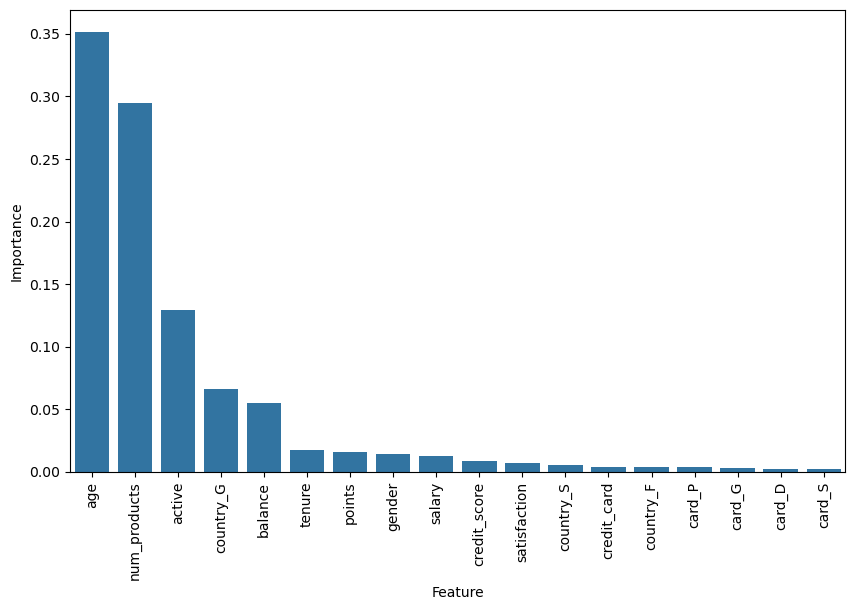

In [1724]:
# Feature importances

feat_imp(gbc)

Age and number of products collectively make up about 65% of the feature importances, after which there is a steep drop in importances. Card type and country are least important, except for if the customer is from Germany, which is the 4th most important feature.

  0%|          | 0/18 [00:00<?, ?it/s]

            Recall  F1-Score
Features                    
1         0.489571  0.489682
2         0.488344  0.549893
3         0.500613  0.566181
4         0.575460  0.592307
5         0.606748  0.606817
6         0.604294  0.606850
7         0.596933  0.604737
8         0.606748  0.614497
9         0.601840  0.611215
10        0.601227  0.609652
11        0.604908  0.615305
12        0.600613  0.609249
13        0.604908  0.611283
14        0.609816  0.615440
15        0.607975  0.614501
16        0.610429  0.614182
17        0.609816  0.614990
18        0.609202  0.615676


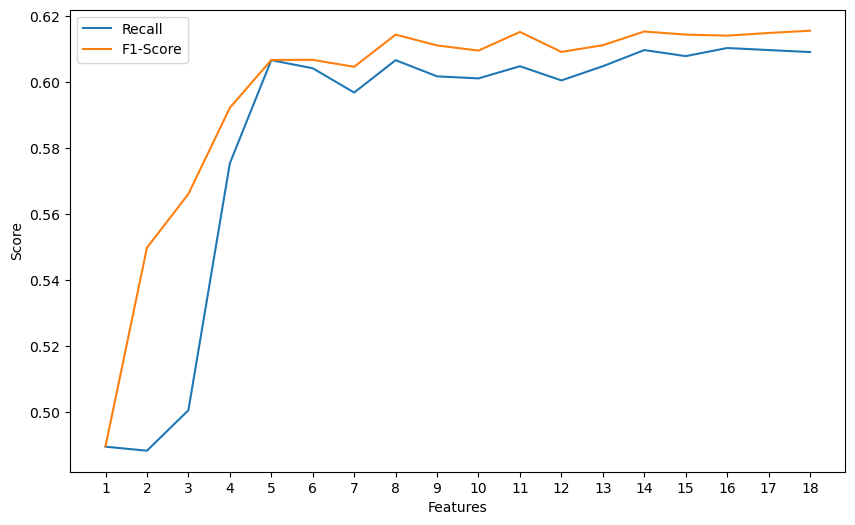

In [1734]:
# Features' effect on model performance

feat_comp(gbc)

The model's recall and f1-score level out after the first 5 features, with a slight improvement overall as more features are added.

## Hist Gradient Boosting Classifier

In [1753]:
# Best model for recall

hgb_re = HistGradientBoostingClassifier(learning_rate=0.03134765616739056, max_iter=377, max_depth=40, min_samples_leaf=29, 
                                     max_leaf_nodes=32, l2_regularization=0.07646734966718845, random_state=42)

# Best model for f1-score

hgb_f1 = HistGradientBoostingClassifier(learning_rate=0.00853199483099034, max_iter=897, max_depth=37, min_samples_leaf=9, 
                                        max_leaf_nodes=26, l2_regularization=0.04861419258358948, random_state=42)

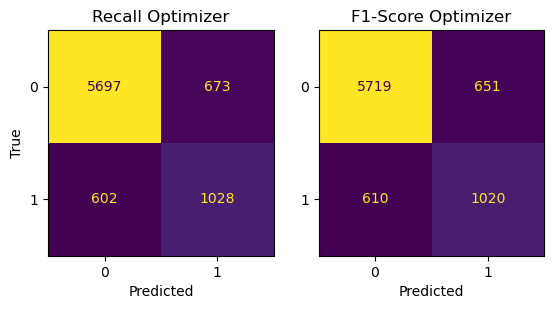

In [1755]:
# Prediction comparisons

cm_comp(hgb_re, hgb_f1)

In [1757]:
print(f'The recall optimized model has {610-602} fewer false negatives and {673-651} more false positives.')

The recall optimized model has 8 fewer false negatives and 22 more false positives.


In [1759]:
# Score comparisons

cr_comp(hgb_re, hgb_f1)

Recall Optimizer
              precision    recall  f1-score   support

           0       0.90      0.89      0.90      6370
           1       0.60      0.63      0.62      1630

    accuracy                           0.84      8000
   macro avg       0.75      0.76      0.76      8000
weighted avg       0.84      0.84      0.84      8000

F1-Score Optimizer
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      6370
           1       0.61      0.63      0.62      1630

    accuracy                           0.84      8000
   macro avg       0.76      0.76      0.76      8000
weighted avg       0.84      0.84      0.84      8000



Overall, the f1-score optimized model looks best.

In [1761]:
# Best model

hgbc = hgb_f1

Hist Gradient Boosting does not a have a feature importances attribute.

## AdaBoost Classifier

In [1767]:
# Best model for recall

ab_re = AdaBoostClassifier(n_estimators=159, learning_rate=0.7814626294518465, random_state=42)

# Best model for f1-score

ab_f1 = AdaBoostClassifier(n_estimators=109, learning_rate=0.846886313092084, random_state=42)

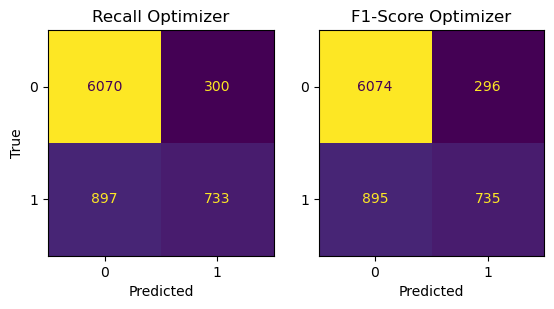

In [1769]:
# Prediction comparisons

cm_comp(ab_re, ab_f1)

In [1771]:
print(f'The recall optimized model has {897-895} more false negatives and {300-296} more false positives.')

The recall optimized model has 2 more false negatives and 4 more false positives.


In [1773]:
# Score comparisons

cr_comp(ab_re, ab_f1)

Recall Optimizer
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      6370
           1       0.71      0.45      0.55      1630

    accuracy                           0.85      8000
   macro avg       0.79      0.70      0.73      8000
weighted avg       0.84      0.85      0.84      8000

F1-Score Optimizer
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      6370
           1       0.71      0.45      0.55      1630

    accuracy                           0.85      8000
   macro avg       0.79      0.70      0.73      8000
weighted avg       0.84      0.85      0.84      8000



Though the predictions of each model are so close that the rounded classification reports are identical, we will go with the f1-score optimized model because it had more overall correct predictions, both for negatives and positives.

In [1776]:
# Best model

abc = ab_f1

         Feature  Importance
0         tenure    0.293578
1         points    0.266055
2            age    0.128440
3   num_products    0.073394
4         salary    0.036697
5   credit_score    0.027523
6         gender    0.027523
7         active    0.027523
8      country_G    0.018349
9   satisfaction    0.018349
10   credit_card    0.018349
11       balance    0.018349
12     country_F    0.009174
13        card_D    0.009174
14        card_G    0.009174
15        card_P    0.009174
16        card_S    0.009174
17     country_S    0.000000


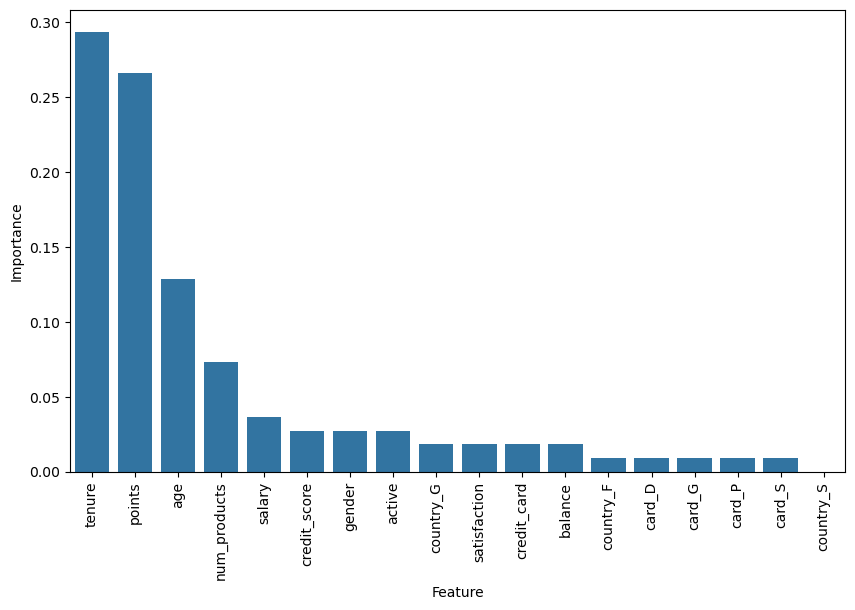

In [1778]:
# Feature importances

feat_imp(abc)

Tenure and points collectively make up about 56% of feature importances, after which there is a steep drop in importances. Card type and country are least important, except for if the customer is from Germany. Age and number of products, which have been the most important features for all prior models, are 3rd and 4th most important respectively for AdaBoost.

  0%|          | 0/18 [00:00<?, ?it/s]

            Recall  F1-Score
Features                    
1         0.000000  0.000000
2         0.000000  0.000000
3         0.184663  0.266499
4         0.485276  0.553250
5         0.483436  0.551924
6         0.479141  0.548730
7         0.433129  0.523552
8         0.424540  0.533939
9         0.453374  0.554048
10        0.455215  0.554359
11        0.457055  0.556591
12        0.447239  0.546696
13        0.450307  0.549743
14        0.447239  0.548296
15        0.449693  0.550995
16        0.449693  0.550759
17        0.450920  0.551631
18        0.450920  0.551839


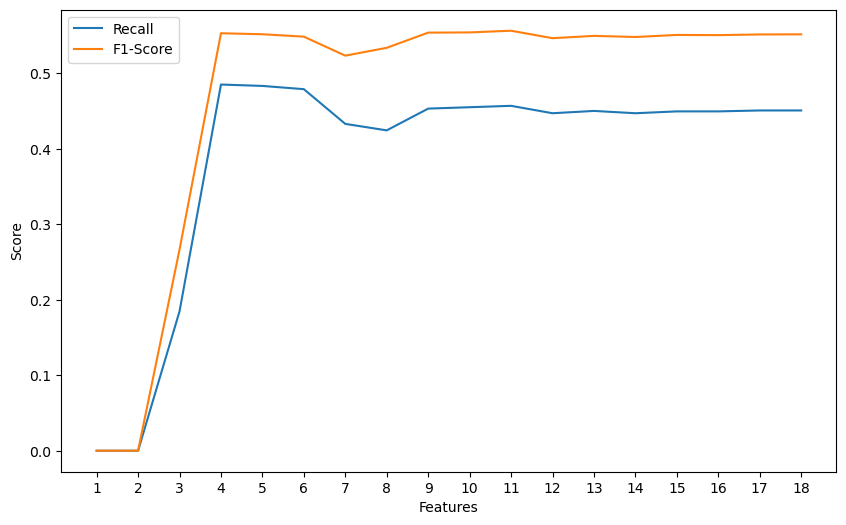

In [1785]:
# Features' effect on model performance

feat_comp(abc)

The model's recall and f1-score level out after the first 4 features, with a slight improvement overall as more features are added.

## XGBoost Classifier

In [1789]:
# Recall optimized model

xgb_re = XGBClassifier(n_estimators=288, learning_rate=0.061636330417928126, gamma=1.3188541387846544, 
                     max_depth=8, min_child_weight=12, subsample=0.8835081674578914, 
                     colsample_bytree=0.5958189298247507, random_state=42, n_jobs=-1)

# F1-score optimized model

xgb_f1 = XGBClassifier(n_estimators=718, learning_rate=0.015312996394551729, gamma=1.9565233918410676, 
                       max_depth=7, min_child_weight=14, subsample=0.824719070849096, 
                       colsample_bytree=0.5000536641438886, random_state=42, n_jobs=-1)

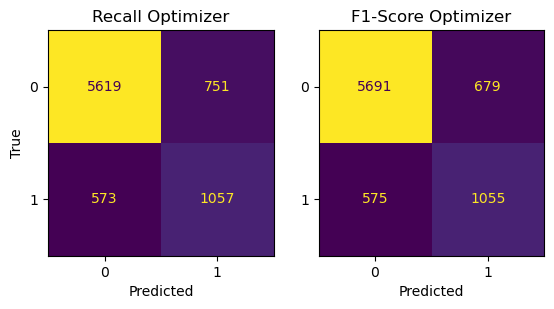

In [1791]:
# Prediction comparisons

cm_comp(xgb_re, xgb_f1)

In [1793]:
print(f'The recall optimized model has {575-573} fewer false negatives and {751-679} more false positives.')

The recall optimized model has 2 fewer false negatives and 72 more false positives.


In [1795]:
# Score comparisons

cr_comp(xgb_re, xgb_f1)

Recall Optimizer
              precision    recall  f1-score   support

           0       0.91      0.88      0.89      6370
           1       0.58      0.65      0.61      1630

    accuracy                           0.83      8000
   macro avg       0.75      0.77      0.75      8000
weighted avg       0.84      0.83      0.84      8000

F1-Score Optimizer
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      6370
           1       0.61      0.65      0.63      1630

    accuracy                           0.84      8000
   macro avg       0.76      0.77      0.76      8000
weighted avg       0.85      0.84      0.85      8000



Overall, the f1-score optimized model looks best.

In [1798]:
# Best model

xgbc = xgb_f1

         Feature  Importance
0   num_products    0.266201
1            age    0.186889
2         active    0.123215
3      country_G    0.073606
4        balance    0.052261
5      country_S    0.033823
6         gender    0.032590
7      country_F    0.032204
8         points    0.020874
9         salary    0.020721
10  satisfaction    0.020700
11  credit_score    0.020235
12        tenure    0.020129
13   credit_card    0.019778
14        card_S    0.019532
15        card_P    0.019299
16        card_D    0.019194
17        card_G    0.018748


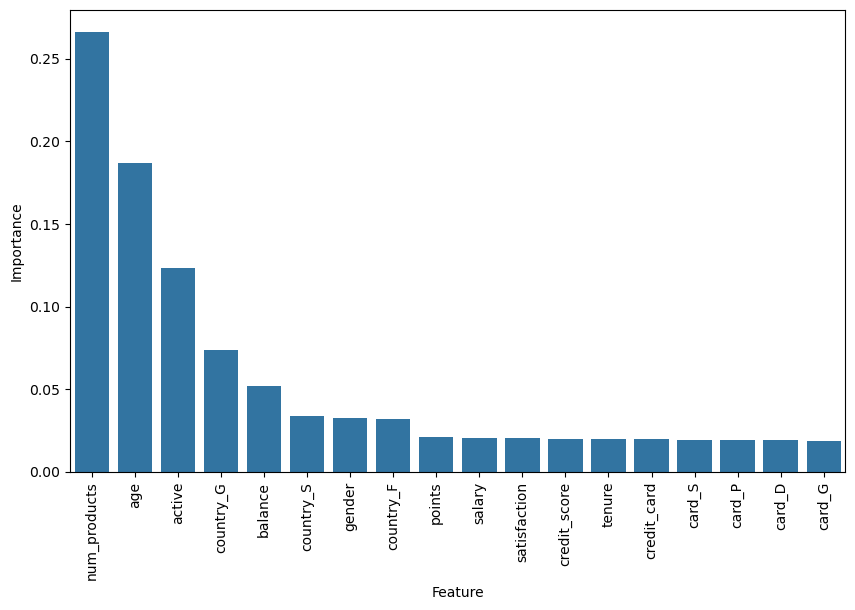

In [1800]:
# Feature importances

feat_imp(xgbc)

Number of products, age, and whether or not a customer is active collectively make up about 58% of the feature importances. Card type is least important. XGBoost places a higher eemphasis on the importance of if a customer is from Spain or France than previous models, with customers from Germany still being the most influential country feature, in 4th place overall.

  0%|          | 0/18 [00:00<?, ?it/s]

            Recall  F1-Score
Features                    
1         0.134969  0.232988
2         0.485890  0.553548
3         0.650307  0.568137
4         0.569325  0.590593
5         0.642945  0.611945
6         0.646012  0.615019
7         0.629448  0.624457
8         0.638037  0.626975
9         0.638037  0.621889
10        0.641104  0.623625
11        0.640491  0.623480
12        0.638037  0.620601
13        0.635583  0.619196
14        0.636196  0.616629
15        0.636196  0.617341
16        0.643558  0.623583
17        0.637423  0.619498
18        0.641104  0.622575


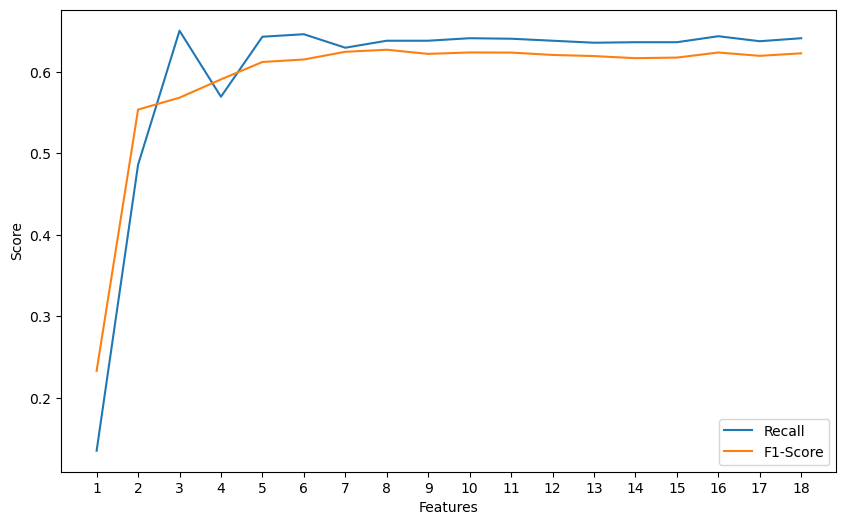

In [1805]:
# Features' effect on model performance

feat_comp(xgbc)

The model's recall peaks with only 3 features. F1-score levels out after the first 2 features, with a slight improvement overall up to a peak at the first 8 features.

## LightGBM Classifier

In [1809]:
# Best model for recall

lgb_re = LGBMClassifier(n_estimators=322, max_depth=0, learning_rate=0.03335525725756855, num_leaves=26, 
                        colsample_bytree=0.6813157390893247, subsample=0.8853493442333064,
                        objective='binary', random_state=42, verbose=-1, n_jobs=-1)

# Best model for f1-score

lgb_f1 = LGBMClassifier(n_estimators=191, max_depth=19, learning_rate=0.025294173033637454, num_leaves=30, 
                        colsample_bytree=0.7501200962447905, subsample=0.5239120285973756,
                        objective='binary', random_state=42, verbose=-1, n_jobs=-1)

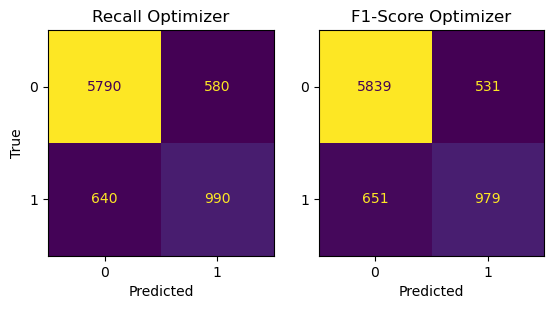

In [1811]:
# Prediction comparisons

cm_comp(lgb_re, lgb_f1)

In [1813]:
print(f'The recall optimized model has {651-640} fewer false negatives and {580-531} more false positives.')

The recall optimized model has 11 fewer false negatives and 49 more false positives.


In [1815]:
# Score comparisons

cr_comp(lgb_re, lgb_f1)

Recall Optimizer
              precision    recall  f1-score   support

           0       0.90      0.91      0.90      6370
           1       0.63      0.61      0.62      1630

    accuracy                           0.85      8000
   macro avg       0.77      0.76      0.76      8000
weighted avg       0.85      0.85      0.85      8000

F1-Score Optimizer
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      6370
           1       0.65      0.60      0.62      1630

    accuracy                           0.85      8000
   macro avg       0.77      0.76      0.77      8000
weighted avg       0.85      0.85      0.85      8000



Overall, the f1-score optimized model looks best.

In [1818]:
# Best model

lgbc = lgb_f1

         Feature  Importance
0        balance         748
1         tenure         640
2            age         614
3         points         556
4   num_products         519
5   satisfaction         320
6         salary         315
7   credit_score         281
8         gender         277
9         active         251
10     country_G         204
11     country_F         153
12        card_G         148
13   credit_card         146
14     country_S         120
15        card_S         101
16        card_D          78
17        card_P          68


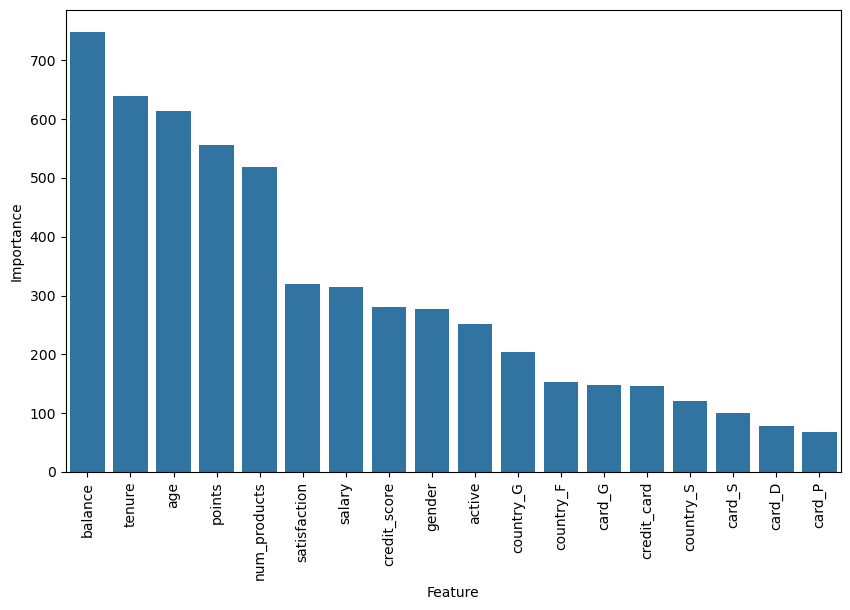

In [1820]:
# Feature importances

feat_imp(lgbc)

LightGBM has several features with more sizeable proportionate contributions that previous models (which are more strongly influenced by a couple of features). Balance, tenure, age, points, and number of products all have sizeable contribtuions. Card type, whether or not the customer has a credit card, and country are least important.

  0%|          | 0/18 [00:00<?, ?it/s]

            Recall  F1-Score
Features                    
1         0.000000  0.000000
2         0.002454  0.004558
3         0.461963  0.478036
4         0.451534  0.473620
5         0.531288  0.567127
6         0.526380  0.563072
7         0.526380  0.563862
8         0.530675  0.564718
9         0.523313  0.560918
10        0.530061  0.574001
11        0.593252  0.614484
12        0.590184  0.614078
13        0.600000  0.622112
14        0.593252  0.613780
15        0.596933  0.617606
16        0.597546  0.619538
17        0.595706  0.618610
18        0.593252  0.615161


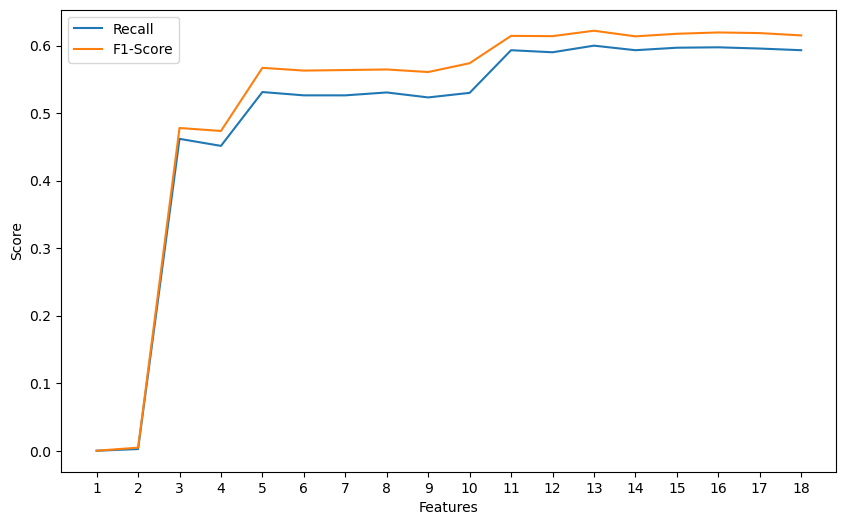

In [1822]:
# Features' effect on model performance

feat_comp(lgbc)

The model's recall and f1-score level out after the first 5 features, with a slight improvement to a peak at 16 features as more features are added.

## CatBoost Classifier

In [1826]:
# Best model for recall

cb_re = CatBoostClassifier(iterations=598, learning_rate=0.023443878098496275, depth=7,
                           random_strength=0.5850280189408111, bagging_temperature=0.8338604000665841, 
                           l2_leaf_reg=8.631900728051564, random_state=42, verbose=0)

# Best model for f1-score

cb_f1 = CatBoostClassifier(iterations=545, learning_rate=0.013560631530876574, depth=6, 
                           random_strength=0.3660344916841721, bagging_temperature=0.2722303737601264, 
                           l2_leaf_reg=2.548492629309027, random_state=42, verbose=0)

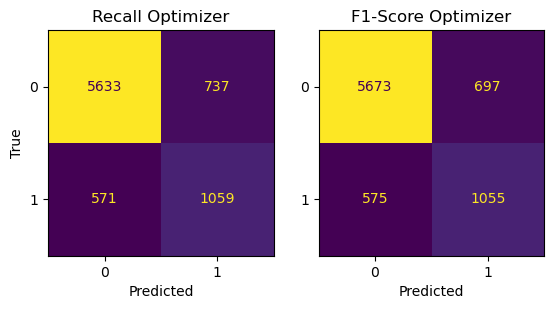

In [1828]:
# Prediction comparisons

cm_comp(cb_re, cb_f1)

In [1832]:
print(f'The recall optimized model has {575-571} fewer false negatives and {737-697} more false positives.')

The recall optimized model has 4 fewer false negatives and 40 more false positives.


In [1836]:
# Score comparisons

cr_comp(cb_re, cb_f1)

Recall Optimizer
              precision    recall  f1-score   support

           0       0.91      0.88      0.90      6370
           1       0.59      0.65      0.62      1630

    accuracy                           0.84      8000
   macro avg       0.75      0.77      0.76      8000
weighted avg       0.84      0.84      0.84      8000

F1-Score Optimizer
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      6370
           1       0.60      0.65      0.62      1630

    accuracy                           0.84      8000
   macro avg       0.76      0.77      0.76      8000
weighted avg       0.85      0.84      0.84      8000



Overall, the f1-score optimized model looks best.

In [1840]:
# Best model

cbc = cb_f1

         Feature  Importance
0   num_products   27.497860
1            age   20.251571
2        balance    9.859890
3         active    7.236069
4      country_G    6.195595
5         tenure    4.580660
6         salary    4.080289
7         gender    3.816531
8         points    3.589042
9   satisfaction    2.848566
10  credit_score    2.674983
11        card_G    1.527465
12   credit_card    1.416423
13     country_S    1.217813
14     country_F    1.062875
15        card_P    0.834047
16        card_S    0.726457
17        card_D    0.583866


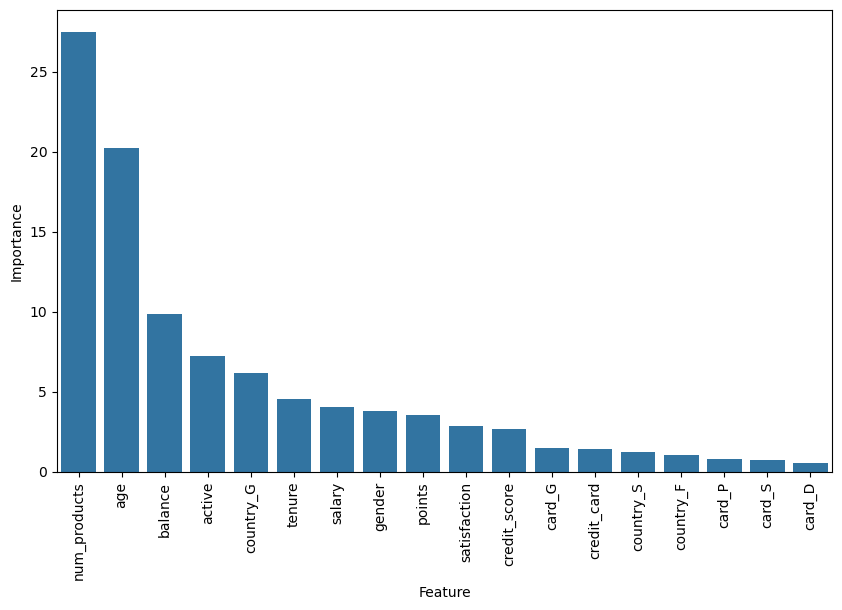

In [1842]:
# Feature importances

feat_imp(cbc)

Number of products and age collectively make up about 48% of the feature importances, after which there is a steep drop in importance. Card type, country (except if the customer is from Germany), and whether or not the customer has a credit card.

  0%|          | 0/18 [00:00<?, ?it/s]

            Recall  F1-Score
Features                    
1         0.134969  0.232988
2         0.491411  0.548289
3         0.544172  0.568085
4         0.617791  0.578360
5         0.636810  0.611604
6         0.641718  0.611950
7         0.636810  0.609458
8         0.642945  0.619268
9         0.634356  0.617374
10        0.634356  0.615812
11        0.639264  0.619371
12        0.639877  0.618023
13        0.641104  0.621362
14        0.636196  0.615935
15        0.646012  0.622869
16        0.643558  0.620655
17        0.644172  0.620372
18        0.643558  0.622107


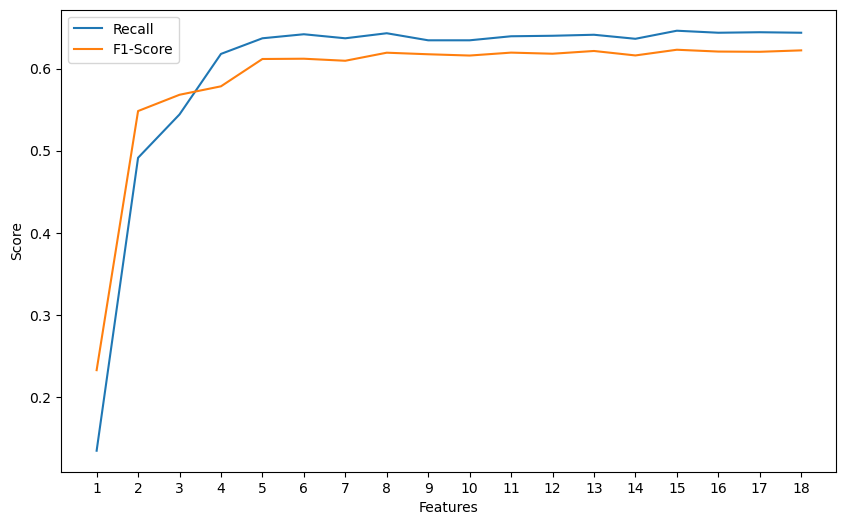

In [1855]:
# Features' effect on model performance

feat_comp(cbc)

The model's recall and f1-score level out after the first 5 features, with a slight improvement overall as more features are added.

## Logistic Regression Classifier

In [1873]:
# Best model for recall

lr_re = LogisticRegression(tol=0.000589445126073971, C=0.2450691606995958, max_iter=322, random_state=42, n_jobs=-1)

# Best model for both f1-score

lr_f1 = LogisticRegression(tol=0.0009440145968962416, C=0.005741852418682025, max_iter=326, random_state=42, n_jobs=-1)

# Neither of these models' performance improved with scaled data

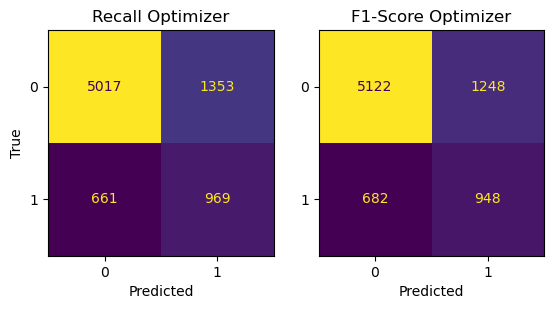

In [1875]:
# Prediction comparisons

cm_comp(lr_re, lr_f1)

In [1877]:
print(f'The recall optimized model has {682-661} fewer false negatives and {1353-1248} more false positives.')

The recall optimized model has 21 fewer false negatives and 105 more false positives.


In [1879]:
# Score comparisons

cr_comp(lr_re, lr_f1)

Recall Optimizer
              precision    recall  f1-score   support

           0       0.88      0.79      0.83      6370
           1       0.42      0.59      0.49      1630

    accuracy                           0.75      8000
   macro avg       0.65      0.69      0.66      8000
weighted avg       0.79      0.75      0.76      8000

F1-Score Optimizer
              precision    recall  f1-score   support

           0       0.88      0.80      0.84      6370
           1       0.43      0.58      0.50      1630

    accuracy                           0.76      8000
   macro avg       0.66      0.69      0.67      8000
weighted avg       0.79      0.76      0.77      8000



Overall, the f1-score optimized model looks best.

In [1882]:
# Best model

lrc = lr_f1

Logistic Regression does not a have a feature importances attribute.

## Support Vector Classifier

In [1916]:
# Best model for recall

sv_re = SVC(C=0.2600853655654022, kernel='linear', random_state=42, probability=True)

# Best for f1-score

sv_f1 = SVC(C=0.020457060411976778, random_state=42, probability=True)    # Performance increases with Standard Scaler

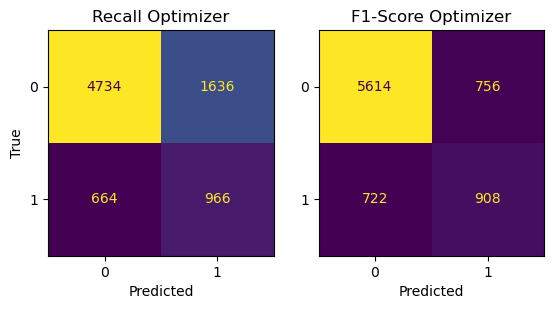

In [1918]:
# Prediction comparisons

cm_comp(sv_re, sv_f1)

In [1920]:
print(f'The recall optimized model has {722-664} fewer false negatives and {1636-756} more false positives.')

The recall optimized model has 58 fewer false negatives and 880 more false positives.


In [1923]:
# Score comparisons

cr_comp(sv_re, sv_f1)

Recall Optimizer
              precision    recall  f1-score   support

           0       0.88      0.74      0.80      6370
           1       0.37      0.59      0.46      1630

    accuracy                           0.71      8000
   macro avg       0.62      0.67      0.63      8000
weighted avg       0.77      0.71      0.73      8000

F1-Score Optimizer
              precision    recall  f1-score   support

           0       0.89      0.88      0.88      6370
           1       0.55      0.56      0.55      1630

    accuracy                           0.82      8000
   macro avg       0.72      0.72      0.72      8000
weighted avg       0.82      0.82      0.82      8000



Overall, the f1-score optimized model looks best. Performance should improve even further for this model after scaling features using the Standard Scaler.

In [1926]:
# Best model

svc = sv_f1 

Support Vector does not a have a feature importances attribute.

## Save Models

In [1965]:
# List of best models

models = [rfc, etc, gbc, hgbc, abc, xgbc, lgbc, cbc, lrc, svc]

In [1967]:
file = 'models.dat'

with open(file, 'wb') as f:
    pickle.dump(models, f)

## Summary

Our models have come a long way. After removing the golden feature, 'complain', recall across all models was below 50%. As we first approached mitigating this by lowering the probability threshold for a positive prediction, we pivoted to measure model performance based on f1-score, so as to balance false negative reduction with minimized false positives. We found ideal probability thresholds for each model that optimized f1-score. We then proceeded to tune hyperparameters for two versions of each model, one that optimized recall and one that optimized f1-score. Overall the f1-score optimization approach resulted in the better models across each type, as determined by accuracy. We also looked at feature importances, and considered the effects of reducing feature input for models. Most models' performance drastically increased across the inclusion of the first 5 features and then showed a slow increase all the way up to the 18th feature, with a few models peaking in performance before the inclusion of all features. Most models ranked the top features (with some variation in order) as:
- age
- number of products
- active
- balance
- Germany

In our next modeling notebook, we will compare all models with one another and select a best model with an appropriate feature selection to present to stakeholders.